# Mount drive

In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Install dependencies

In [ ]:
!pip install discopy==1.1.4
!pip install lambeq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.9/144.9 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.1/152.1 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.3/364.3 kB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.5/103.5 kB 10.7 MB/s eta 0:00:00


# Import libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

# QNLP
from lambeq.tokeniser import SpacyTokeniser
from lambeq import BobcatParser, spiders_reader, cups_reader, TreeReader, TreeReaderMode, stairs_reader
from lambeq import Rewriter, SimpleRewriteRule, remove_cups, AtomicType, TensorAnsatz, SpiderAnsatz
from discopy.tensor import Dim
from discopy.grammar.pregroup import Cap, Id, Diagram
S = AtomicType.SENTENCE
N = AtomicType.NOUN
P = AtomicType.PREPOSITIONAL_PHRASE
C = AtomicType.CONJUNCTION

# Training
from lambeq import PytorchModel, PytorchTrainer, Dataset, BinaryCrossEntropyLoss
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold

# SEED for reproducibility
import random
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Load data

In [ ]:
QUANTUM_PATH = '/content/drive/MyDrive/Tesi/Master-Thesis/data/processed/quantum.csv'
CLASSICAL_PATH = '/content/drive/MyDrive/Tesi/Master-Thesis/data/processed/classical.csv'

df = pd.read_csv(CLASSICAL_PATH, index_col=False)

# SE_CLASSICAL_DS_PATH = '/content/drive/MyDrive/Tesi/Master-Thesis/data/processed/balanced/classical_SE.csv'
# US_CLASSICAL_DS_PATH = '/content/drive/MyDrive/Tesi/Master-Thesis/data/processed/balanced/classical_US.csv'
# O_CLASSICAL_DS_PATH = '/content/drive/MyDrive/Tesi/Master-Thesis/data/processed/balanced/classical_O.csv'
# PE_CLASSICAL_DS_PATH = '/content/drive/MyDrive/Tesi/Master-Thesis/data/processed/balanced/classical_PE.csv'

# se_df = pd.read_csv(SE_CLASSICAL_DS_PATH, index_col=False)
# us_df = pd.read_csv(US_CLASSICAL_DS_PATH, index_col=False)
# o_df = pd.read_csv(O_CLASSICAL_DS_PATH, index_col=False)
# pe_df = pd.read_csv(PE_CLASSICAL_DS_PATH, index_col=False)

# Create string-diagrams
Uncomment rows for different readers

In [ ]:
def create_binary_diagrams(df, reader):
    diagrams = []
    se_targets, us_targets, o_targets, pe_targets = [], [], [], []
    for _, row in enumerate(df.to_numpy()):
        sentence, target = row[0], row[1]
        try:
            diagrams.append(reader.sentence2diagram(sentence))
        except Exception as e:
            print(sentence)
            print(e)
            continue
        if target == "SE":
            se_targets.append([1.0, 0.0])
            us_targets.append([0.0, 1.0])
            o_targets.append([0.0, 1.0])
            pe_targets.append([0.0, 1.0])
        elif target == "US":
            se_targets.append([0.0, 1.0])
            us_targets.append([1.0, 0.0])
            o_targets.append([0.0, 1.0])
            pe_targets.append([0.0, 1.0])
        elif target == "O":
            se_targets.append([0.0, 1.0])
            us_targets.append([0.0, 1.0])
            o_targets.append([1.0, 0.0])
            pe_targets.append([0.0, 1.0])
        elif target == "PE":
            se_targets.append([0.0, 1.0])
            us_targets.append([0.0, 1.0])
            o_targets.append([0.0, 1.0])
            pe_targets.append([1.0, 0.0])
    return diagrams, se_targets, us_targets, o_targets, pe_targets

reader = spiders_reader
# reader = cups_reader
# reader = stairs_reader
# reader = TreeReader(ccg_parser=BobcatParser, mode = TreeReaderMode.RULE_TYPE)

# reader = BobcatParser(root_cats=['S'])

diagrams, se_targets, us_targets, o_targets, pe_targets = create_binary_diagrams(df, reader)

# Rewrite string-diagrams
This step is not performed for linear readers (spiders, cups, etc.).

In [ ]:
# def normalize_diagrams(diagrams):
#     normalized_diagrams = []
#     for i, diagram in enumerate(diagrams):
#         try:
#             normalized_diagrams.append(rewriter(diagram).normal_form())
#         except Exception as e:
#             print(e)
#             diagram.draw()
#             continue
#     return normalized_diagrams

# import nltk
# nltk.download('punkt')

# from nltk.probability import FreqDist
# from nltk.tokenize import word_tokenize
# from lambeq import UnknownWordsRewriteRule

# all_words = [word for tokens in se_df['RequirementText'].apply(lambda x: word_tokenize(x)) for word in tokens]
# freq_dist = FreqDist(all_words)
# common_words = [word for word, freq in freq_dist.items() if freq >= 2]

# unknown_rule = UnknownWordsRewriteRule(common_words)

# rewriter = Rewriter(['prepositional_phrase', 'determiner', 'connector', 'auxiliary', 'preadverb', 'coordination'])
# diagrams = normalize_diagrams(diagrams)

# Parameterize diagrams
Uncomment rows for different anstaze

In [ ]:
def create_networks(diagrams, ansatz):
    networks = []
    for i, diagram in enumerate(diagrams):
        try:
            networks.append(ansatz(remove_cups(diagram)))
        except Exception as e:
            print(e)
            diagram.draw(figsize=(8,5), fontsize=8)
            continue
    return networks

ob_map = {
    S: Dim(2),
    N: Dim(2),
    P: Dim(2)
}

ansatz = TensorAnsatz(ob_map)

networks = create_networks(diagrams, ansatz)

# # check for codomain errors
# for i,c in enumerate(networks):
#     if str(c.cod) != 'Dim(2)':
#         networks[i].draw()

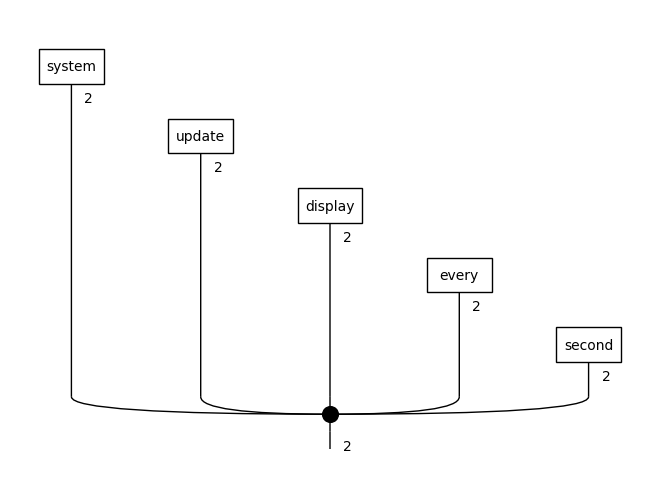

In [ ]:
networks[0].draw()

# Define evalutation metrics

In [ ]:
def accuracy(y_hat, y):
    y_true = torch.argmax(y, dim=1)
    y_pred = torch.argmax(y_hat, dim=1)
    return accuracy_score(y_true, y_pred)

def f1(y_hat, y):
    y_true = torch.argmax(y, dim=1)
    y_pred = torch.argmax(y_hat, dim=1)
    return f1_score(y_true, y_pred)

eval_metrics = {'acc': accuracy,
                'f1': f1}

# Define model

In [ ]:
class ClassicalModel(PytorchModel):
    def __init__(self):
        super().__init__()

    def forward(self, input):
        x = self.get_diagram_output(input)
        return x

# Training

Processing Fold 1 ...


Epoch 5:   train/loss: 0.2476   valid/loss: 0.5402   train/acc: 0.8270   train/f1: 0.8980   valid/acc: 0.8056   valid/f1: 0.8923
Epoch 10:  train/loss: 0.1060   valid/loss: 0.4005   train/acc: 0.8742   train/f1: 0.9219   valid/acc: 0.8333   valid/f1: 0.9062
Epoch 15:  train/loss: 0.0248   valid/loss: 0.2801   train/acc: 0.9277   train/f1: 0.9510   valid/acc: 0.8333   valid/f1: 0.8929
Epoch 20:  train/loss: 0.2779   valid/loss: 0.3433   train/acc: 0.9780   train/f1: 0.9821   valid/acc: 0.8333   valid/f1: 0.8929

Training completed!


Processing Fold 2 ...


Epoch 5:   train/loss: 0.3496   valid/loss: 0.4972   train/acc: 0.8333   train/f1: 0.9010   valid/acc: 0.8056   valid/f1: 0.8923
Epoch 10:  train/loss: 0.3613   valid/loss: 0.5201   train/acc: 0.8962   train/f1: 0.9361   valid/acc: 0.7500   valid/f1: 0.8525
Epoch 15:  train/loss: 0.1378   valid/loss: 0.7914   train/acc: 0.9245   train/f1: 0.9518   valid/acc: 0.8333   valid/f1: 0.8966
Epoch 20:  train/loss: 0.0041   valid/loss: 1.3244   train/acc: 0.9717   train/f1: 0.9818   valid/acc: 0.7778   valid/f1: 0.8519

Training completed!


Processing Fold 3 ...


Epoch 5:   train/loss: 0.2101   valid/loss: 0.5137   train/acc: 0.8365   train/f1: 0.9015   valid/acc: 0.8056   valid/f1: 0.8923
Epoch 10:  train/loss: 0.0003   valid/loss: 0.3498   train/acc: 0.8962   train/f1: 0.9333   valid/acc: 0.8056   valid/f1: 0.8889
Epoch 15:  train/loss: 0.0873   valid/loss: 0.3622   train/acc: 0.9497   train/f1: 0.9685   valid/acc: 0.8889   valid/f1: 0.9310
Epoch 20:  train/loss: 0.1156   valid/loss: 0.6704   train/acc: 0.9780   train/f1: 0.9859   valid/acc: 0.7500   valid/f1: 0.8302

Training completed!


Processing Fold 4 ...


Epoch 5:   train/loss: 0.4595   valid/loss: 0.4962   train/acc: 0.8365   train/f1: 0.9018   valid/acc: 0.8333   valid/f1: 0.9032
Epoch 10:  train/loss: 0.0714   valid/loss: 0.2624   train/acc: 0.8962   train/f1: 0.9328   valid/acc: 0.8611   valid/f1: 0.9206
Epoch 15:  train/loss: 0.1556   valid/loss: 0.1720   train/acc: 0.9245   train/f1: 0.9510   valid/acc: 0.9444   valid/f1: 0.9655
Epoch 20:  train/loss: 0.0034   valid/loss: 0.1681   train/acc: 0.9591   train/f1: 0.9735   valid/acc: 0.8889   valid/f1: 0.9259

Training completed!


Processing Fold 5 ...


Epoch 5:   train/loss: 0.3746   valid/loss: 0.5742   train/acc: 0.8213   train/f1: 0.8943   valid/acc: 0.8000   valid/f1: 0.8889
Epoch 10:  train/loss: 0.2279   valid/loss: 0.6420   train/acc: 0.8683   train/f1: 0.9195   valid/acc: 0.7429   valid/f1: 0.8525
Epoch 15:  train/loss: 0.0303   valid/loss: 0.5849   train/acc: 0.9028   train/f1: 0.9371   valid/acc: 0.8000   valid/f1: 0.8814
Epoch 20:  train/loss: 0.1696   valid/loss: 0.7559   train/acc: 0.9624   train/f1: 0.9738   valid/acc: 0.8571   valid/f1: 0.9123

Training completed!


Processing Fold 6 ...


Epoch 5:   train/loss: 0.2178   valid/loss: 0.4440   train/acc: 0.8150   train/f1: 0.8921   valid/acc: 0.8000   valid/f1: 0.8889
Epoch 10:  train/loss: 0.1316   valid/loss: 0.4452   train/acc: 0.8903   train/f1: 0.9321   valid/acc: 0.8000   valid/f1: 0.8814
Epoch 15:  train/loss: 0.0693   valid/loss: 0.6389   train/acc: 0.9436   train/f1: 0.9604   valid/acc: 0.8286   valid/f1: 0.8929
Epoch 20:  train/loss: 0.0553   valid/loss: 0.7596   train/acc: 0.9749   train/f1: 0.9829   valid/acc: 0.8286   valid/f1: 0.8889

Training completed!


Processing Fold 7 ...


Epoch 5:   train/loss: 0.2047   valid/loss: 0.4321   train/acc: 0.8339   train/f1: 0.8972   valid/acc: 0.8571   valid/f1: 0.9206
Epoch 10:  train/loss: 0.1035   valid/loss: 0.2650   train/acc: 0.8809   train/f1: 0.9285   valid/acc: 0.9143   valid/f1: 0.9508
Epoch 15:  train/loss: 0.0654   valid/loss: 0.2635   train/acc: 0.9216   train/f1: 0.9497   valid/acc: 0.9429   valid/f1: 0.9667
Epoch 20:  train/loss: 1.2380   valid/loss: 0.3075   train/acc: 0.9404   train/f1: 0.9601   valid/acc: 0.9143   valid/f1: 0.9492

Training completed!


Processing Fold 8 ...


Epoch 5:   train/loss: 0.3227   valid/loss: 0.4530   train/acc: 0.8119   train/f1: 0.8888   valid/acc: 0.8000   valid/f1: 0.8889
Epoch 10:  train/loss: 0.1746   valid/loss: 0.4372   train/acc: 0.8715   train/f1: 0.9168   valid/acc: 0.8000   valid/f1: 0.8814
Epoch 15:  train/loss: 0.0468   valid/loss: 0.7547   train/acc: 0.9561   train/f1: 0.9708   valid/acc: 0.8000   valid/f1: 0.8727
Epoch 20:  train/loss: 0.0350   valid/loss: 1.2575   train/acc: 0.9812   train/f1: 0.9880   valid/acc: 0.8286   valid/f1: 0.8889

Training completed!


Processing Fold 9 ...


Epoch 5:   train/loss: 0.4189   valid/loss: 0.4893   train/acc: 0.8182   train/f1: 0.8950   valid/acc: 0.8286   valid/f1: 0.9062
Epoch 10:  train/loss: 0.4040   valid/loss: 0.6785   train/acc: 0.8621   train/f1: 0.9170   valid/acc: 0.7429   valid/f1: 0.8525
Epoch 15:  train/loss: 0.1835   valid/loss: 0.5407   train/acc: 0.8997   train/f1: 0.9372   valid/acc: 0.8000   valid/f1: 0.8814
Epoch 20:  train/loss: 0.0707   valid/loss: 0.6527   train/acc: 0.9498   train/f1: 0.9697   valid/acc: 0.8000   valid/f1: 0.8727

Training completed!


Processing Fold 10 ...


Epoch 5:   train/loss: 0.4503   valid/loss: 0.5686   train/acc: 0.8339   train/f1: 0.8968   valid/acc: 0.8286   valid/f1: 0.9062
Epoch 10:  train/loss: 0.1853   valid/loss: 0.7710   train/acc: 0.8777   train/f1: 0.9239   valid/acc: 0.8286   valid/f1: 0.9032
Epoch 15:  train/loss: 0.0026   valid/loss: 1.3403   train/acc: 0.9655   train/f1: 0.9772   valid/acc: 0.8286   valid/f1: 0.9000
Epoch 20:  train/loss: 0.0141   valid/loss: 1.8899   train/acc: 0.9875   train/f1: 0.9908   valid/acc: 0.8000   valid/f1: 0.8814

Training completed!


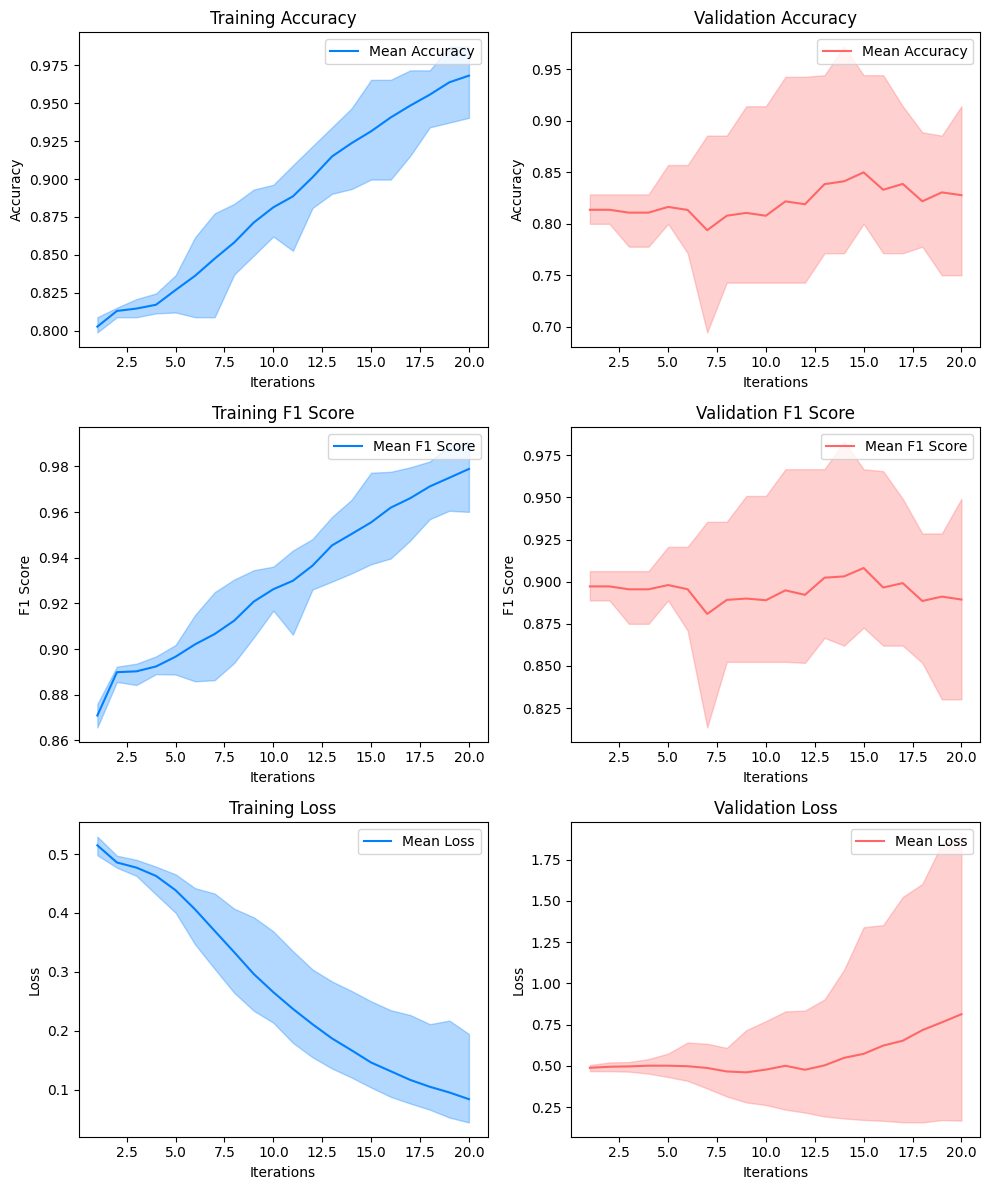

Processing Fold 1 ...


Epoch 5:   train/loss: 0.8364   valid/loss: 0.6440   train/acc: 0.7830   train/f1: 0.8702   valid/acc: 0.7778   valid/f1: 0.8750
Epoch 10:  train/loss: 0.1770   valid/loss: 0.6429   train/acc: 0.8396   train/f1: 0.8978   valid/acc: 0.6111   valid/f1: 0.7407
Epoch 15:  train/loss: 0.1651   valid/loss: 0.8140   train/acc: 0.9434   train/f1: 0.9601   valid/acc: 0.6667   valid/f1: 0.7692
Epoch 20:  train/loss: 0.0002   valid/loss: 0.9837   train/acc: 0.9686   train/f1: 0.9762   valid/acc: 0.6944   valid/f1: 0.7755

Training completed!


Processing Fold 2 ...


Epoch 5:   train/loss: 0.6527   valid/loss: 0.5252   train/acc: 0.7830   train/f1: 0.8703   valid/acc: 0.7778   valid/f1: 0.8750
Epoch 10:  train/loss: 0.4537   valid/loss: 0.5437   train/acc: 0.7862   train/f1: 0.8755   valid/acc: 0.7778   valid/f1: 0.8750
Epoch 15:  train/loss: 0.2110   valid/loss: 0.6895   train/acc: 0.8742   train/f1: 0.9198   valid/acc: 0.7222   valid/f1: 0.8387
Epoch 20:  train/loss: 0.0513   valid/loss: 1.1532   train/acc: 0.9119   train/f1: 0.9436   valid/acc: 0.6389   valid/f1: 0.7719

Training completed!


Processing Fold 3 ...


Epoch 5:   train/loss: 0.6634   valid/loss: 0.5253   train/acc: 0.7830   train/f1: 0.8695   valid/acc: 0.7778   valid/f1: 0.8750
Epoch 10:  train/loss: 0.2952   valid/loss: 2.2670   train/acc: 0.7736   train/f1: 0.8600   valid/acc: 0.7222   valid/f1: 0.8276
Epoch 15:  train/loss: 0.1362   valid/loss: 5.3607   train/acc: 0.9340   train/f1: 0.9555   valid/acc: 0.7778   valid/f1: 0.8571
Epoch 20:  train/loss: 0.0401   valid/loss: 9.0288   train/acc: 0.9560   train/f1: 0.9685   valid/acc: 0.8056   valid/f1: 0.8727

Training completed!


Processing Fold 4 ...


Epoch 5:   train/loss: 0.8596   valid/loss: 0.5747   train/acc: 0.7830   train/f1: 0.8707   valid/acc: 0.7778   valid/f1: 0.8750
Epoch 10:  train/loss: 0.5187   valid/loss: 0.7048   train/acc: 0.7830   train/f1: 0.8705   valid/acc: 0.7778   valid/f1: 0.8750
Epoch 15:  train/loss: 0.8260   valid/loss: 0.8150   train/acc: 0.8805   train/f1: 0.9148   valid/acc: 0.7222   valid/f1: 0.8148
Epoch 20:  train/loss: 0.0424   valid/loss: 1.1232   train/acc: 0.9403   train/f1: 0.9566   valid/acc: 0.7222   valid/f1: 0.8148

Training completed!


Processing Fold 5 ...


Epoch 5:   train/loss: 0.7438   valid/loss: 0.5046   train/acc: 0.7806   train/f1: 0.8683   valid/acc: 0.8000   valid/f1: 0.8889
Epoch 10:  train/loss: 0.2880   valid/loss: 0.4536   train/acc: 0.7900   train/f1: 0.8755   valid/acc: 0.7714   valid/f1: 0.8621
Epoch 15:  train/loss: 0.0561   valid/loss: 0.6254   train/acc: 0.8840   train/f1: 0.9146   valid/acc: 0.7429   valid/f1: 0.8302
Epoch 20:  train/loss: 0.2141   valid/loss: 0.8486   train/acc: 0.9342   train/f1: 0.9598   valid/acc: 0.7429   valid/f1: 0.8364

Training completed!


Processing Fold 6 ...


Epoch 5:   train/loss: 0.5552   valid/loss: 0.5619   train/acc: 0.7774   train/f1: 0.8673   valid/acc: 0.8000   valid/f1: 0.8889
Epoch 10:  train/loss: 0.1113   valid/loss: 1.1882   train/acc: 0.8683   train/f1: 0.9154   valid/acc: 0.7143   valid/f1: 0.8276
Epoch 15:  train/loss: 0.3872   valid/loss: 1.5636   train/acc: 0.9028   train/f1: 0.9378   valid/acc: 0.6857   valid/f1: 0.8070
Epoch 20:  train/loss: 0.2839   valid/loss: 1.5616   train/acc: 0.9216   train/f1: 0.9456   valid/acc: 0.7143   valid/f1: 0.8214

Training completed!


Processing Fold 7 ...


Epoch 5:   train/loss: 0.7509   valid/loss: 0.5649   train/acc: 0.7806   train/f1: 0.8707   valid/acc: 0.8000   valid/f1: 0.8889
Epoch 10:  train/loss: 0.2421   valid/loss: 0.7649   train/acc: 0.7837   train/f1: 0.8709   valid/acc: 0.7429   valid/f1: 0.8525
Epoch 15:  train/loss: 0.2480   valid/loss: 1.0747   train/acc: 0.9028   train/f1: 0.9326   valid/acc: 0.7714   valid/f1: 0.8571
Epoch 20:  train/loss: 0.3111   valid/loss: 1.6190   train/acc: 0.9624   train/f1: 0.9733   valid/acc: 0.6000   valid/f1: 0.7200

Training completed!


Processing Fold 8 ...


Epoch 5:   train/loss: 0.6920   valid/loss: 0.7381   train/acc: 0.7837   train/f1: 0.8702   valid/acc: 0.7714   valid/f1: 0.8710
Epoch 10:  train/loss: 0.2447   valid/loss: 0.9144   train/acc: 0.8370   train/f1: 0.8893   valid/acc: 0.8000   valid/f1: 0.8727
Epoch 15:  train/loss: 0.2944   valid/loss: 1.1361   train/acc: 0.9279   train/f1: 0.9536   valid/acc: 0.7429   valid/f1: 0.8364
Epoch 20:  train/loss: 0.1062   valid/loss: 1.6104   train/acc: 0.9687   train/f1: 0.9778   valid/acc: 0.7429   valid/f1: 0.8364

Training completed!


Processing Fold 9 ...


Epoch 5:   train/loss: 0.5504   valid/loss: 0.6402   train/acc: 0.7837   train/f1: 0.8721   valid/acc: 0.7714   valid/f1: 0.8710
Epoch 10:  train/loss: 0.6393   valid/loss: 0.7165   train/acc: 0.7994   train/f1: 0.8776   valid/acc: 0.7429   valid/f1: 0.8525
Epoch 15:  train/loss: 0.2215   valid/loss: 0.8335   train/acc: 0.8966   train/f1: 0.9256   valid/acc: 0.8000   valid/f1: 0.8627
Epoch 20:  train/loss: 0.2258   valid/loss: 1.1082   train/acc: 0.9436   train/f1: 0.9592   valid/acc: 0.8000   valid/f1: 0.8627

Training completed!


Processing Fold 10 ...


Epoch 5:   train/loss: 0.2537   valid/loss: 0.8423   train/acc: 0.7837   train/f1: 0.8735   valid/acc: 0.7714   valid/f1: 0.8710
Epoch 10:  train/loss: 0.4314   valid/loss: 0.9312   train/acc: 0.8589   train/f1: 0.9039   valid/acc: 0.7143   valid/f1: 0.8000
Epoch 15:  train/loss: 0.6785   valid/loss: 0.9197   train/acc: 0.9185   train/f1: 0.9407   valid/acc: 0.8000   valid/f1: 0.8571
Epoch 20:  train/loss: 0.0197   valid/loss: 0.9360   train/acc: 0.9498   train/f1: 0.9662   valid/acc: 0.7714   valid/f1: 0.8333

Training completed!


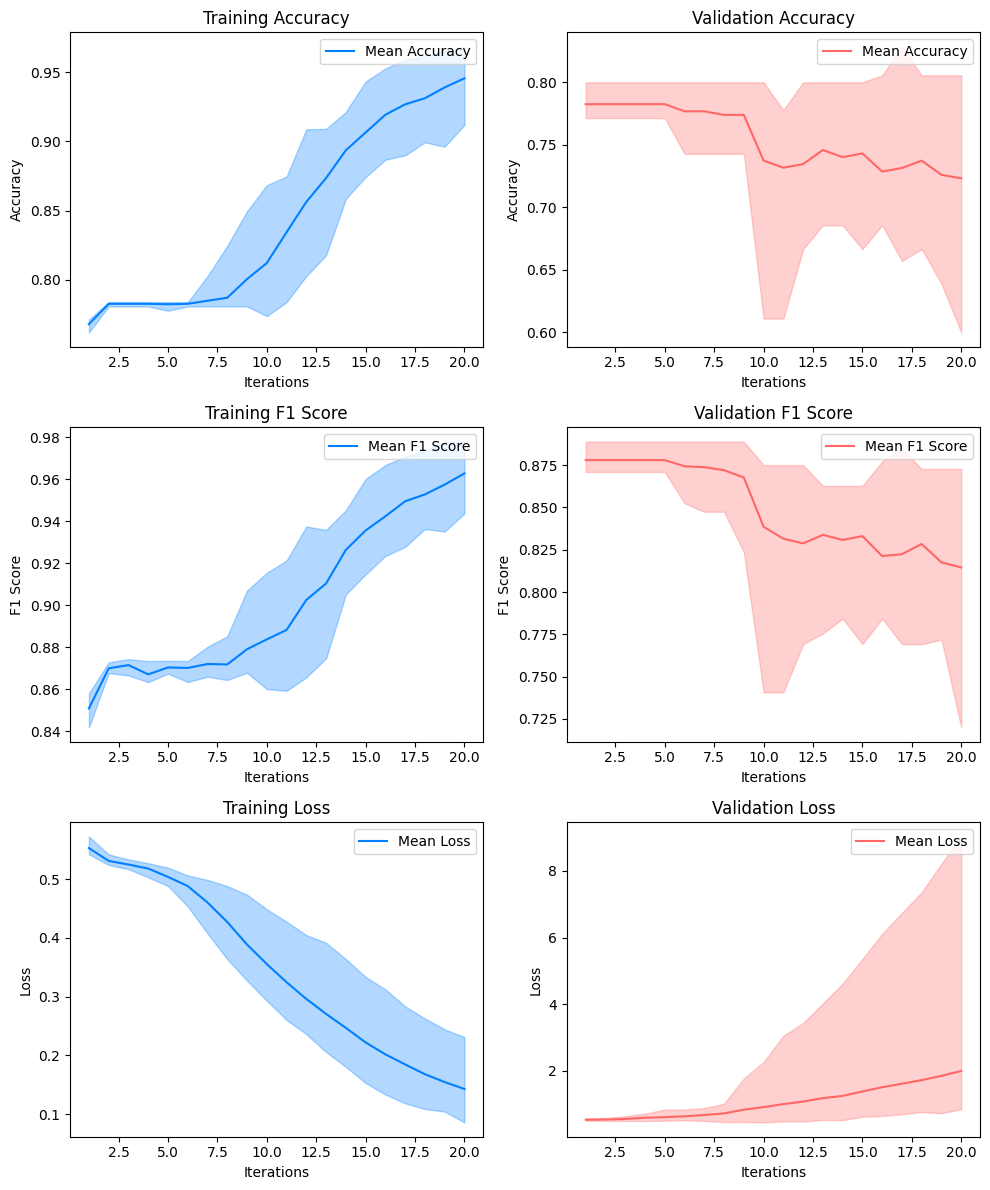

Processing Fold 1 ...


Epoch 5:   train/loss: 0.4876   valid/loss: 0.5460   train/acc: 0.6918   train/f1: 0.7654   valid/acc: 0.7222   valid/f1: 0.7368
Epoch 10:  train/loss: 0.2363   valid/loss: 0.4899   train/acc: 0.8742   train/f1: 0.8766   valid/acc: 0.6944   valid/f1: 0.7660
Epoch 15:  train/loss: 0.4182   valid/loss: 0.4683   train/acc: 0.9434   train/f1: 0.9531   valid/acc: 0.7778   valid/f1: 0.8000
Epoch 20:  train/loss: 0.0088   valid/loss: 0.4516   train/acc: 0.9780   train/f1: 0.9849   valid/acc: 0.8611   valid/f1: 0.8837

Training completed!


Processing Fold 2 ...


Epoch 5:   train/loss: 0.6079   valid/loss: 0.7301   train/acc: 0.7579   train/f1: 0.7971   valid/acc: 0.7500   valid/f1: 0.7907
Epoch 10:  train/loss: 0.4638   valid/loss: 1.0051   train/acc: 0.9025   train/f1: 0.9068   valid/acc: 0.8056   valid/f1: 0.8372
Epoch 15:  train/loss: 0.0711   valid/loss: 1.4680   train/acc: 0.9686   train/f1: 0.9707   valid/acc: 0.7778   valid/f1: 0.8095
Epoch 20:  train/loss: 0.0039   valid/loss: 2.0691   train/acc: 0.9937   train/f1: 0.9949   valid/acc: 0.7778   valid/f1: 0.8095

Training completed!


Processing Fold 3 ...


Epoch 5:   train/loss: 0.4801   valid/loss: 0.5661   train/acc: 0.6824   train/f1: 0.7609   valid/acc: 0.6944   valid/f1: 0.7755
Epoch 10:  train/loss: 0.9447   valid/loss: 0.6020   train/acc: 0.8585   train/f1: 0.8583   valid/acc: 0.6667   valid/f1: 0.7143
Epoch 15:  train/loss: 0.1556   valid/loss: 0.5528   train/acc: 0.9214   train/f1: 0.9262   valid/acc: 0.7778   valid/f1: 0.8261
Epoch 20:  train/loss: 0.0288   valid/loss: 0.4989   train/acc: 0.9623   train/f1: 0.9669   valid/acc: 0.8056   valid/f1: 0.8372

Training completed!


Processing Fold 4 ...


Epoch 5:   train/loss: 0.6183   valid/loss: 0.5880   train/acc: 0.6792   train/f1: 0.7542   valid/acc: 0.6111   valid/f1: 0.6667
Epoch 10:  train/loss: 0.1465   valid/loss: 0.5400   train/acc: 0.8396   train/f1: 0.8569   valid/acc: 0.7500   valid/f1: 0.7907
Epoch 15:  train/loss: 0.3581   valid/loss: 0.5572   train/acc: 0.9119   train/f1: 0.9300   valid/acc: 0.7778   valid/f1: 0.8095
Epoch 20:  train/loss: 0.0305   valid/loss: 0.7818   train/acc: 0.9686   train/f1: 0.9713   valid/acc: 0.8611   valid/f1: 0.8889

Training completed!


Processing Fold 5 ...


Epoch 5:   train/loss: 0.5723   valid/loss: 0.5347   train/acc: 0.6865   train/f1: 0.7407   valid/acc: 0.7714   valid/f1: 0.8182
Epoch 10:  train/loss: 0.1818   valid/loss: 0.4161   train/acc: 0.8683   train/f1: 0.8867   valid/acc: 0.8286   valid/f1: 0.8696
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
Epoch 15:  train/loss: 0.0538   valid/loss: 0.3636   train/acc: 0.9436   train/f1: 0.9531   valid/acc: 0.8857   valid/f1: 0.9091
Epoch 20:  train/loss: 0.0265   valid/loss: 0.3761   train/acc: 0.9781   train/f1: 0.9841   valid/acc: 0.8286   valid/f1: 0.8636

Training completed!


Processing Fold 6 ...


Epoch 5:   train/loss: 0.5459   valid/loss: 0.5225   train/acc: 0.7367   train/f1: 0.7679   valid/acc: 0.6286   valid/f1: 0.6829
Epoch 10:  train/loss: 0.5674   valid/loss: 0.4892   train/acc: 0.8715   train/f1: 0.8908   valid/acc: 0.8000   valid/f1: 0.8293
Epoch 15:  train/loss: 0.3170   valid/loss: 0.7643   train/acc: 0.9404   train/f1: 0.9461   valid/acc: 0.7714   valid/f1: 0.8000
Epoch 20:  train/loss: 0.0964   valid/loss: 0.8510   train/acc: 0.9843   train/f1: 0.9876   valid/acc: 0.8286   valid/f1: 0.8636

Training completed!


Processing Fold 7 ...


Epoch 5:   train/loss: 0.8764   valid/loss: 1.0068   train/acc: 0.6834   train/f1: 0.7653   valid/acc: 0.7143   valid/f1: 0.7826
Epoch 10:  train/loss: 0.3943   valid/loss: 1.6563   train/acc: 0.8495   train/f1: 0.8678   valid/acc: 0.8286   valid/f1: 0.8636
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
Epoch 15:  train/loss: 0.0351   valid/loss: 2.2703   train/acc: 0.9373   train/f1: 0.9457   valid/acc: 0.8286   valid/f1: 0.8636
Epoch 20:  train/loss: 0.3394   valid/loss: 3.3842   train/acc: 0.9875   train/f1: 0.9822   valid/acc: 0.8000   valid/f1: 0.8372

Training completed!


Processing Fold 8 ...


Epoch 5:   train/loss: 0.4807   valid/loss: 0.4459   train/acc: 0.7461   train/f1: 0.7754   valid/acc: 0.7143   valid/f1: 0.7826
Epoch 10:  train/loss: 0.1896   valid/loss: 0.3402   train/acc: 0.8746   train/f1: 0.8892   valid/acc: 0.7429   valid/f1: 0.8085
Epoch 15:  train/loss: 0.5217   valid/loss: 0.3349   train/acc: 0.9561   train/f1: 0.9668   valid/acc: 0.8000   valid/f1: 0.8293
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
Epoch 20:  train/loss: 0.0343   valid/loss: 0.4758   train/acc: 0.9875   train/f1: 0.9907   valid/acc: 0.8571   valid/f1: 0.8837

Training completed!


Processing Fold 9 ...


Epoch 5:   train/loss: 0.4936   valid/loss: 0.7589   train/acc: 0.7210   train/f1: 0.7717   valid/acc: 0.7143   valid/f1: 0.7500
Epoch 10:  train/loss: 0.3441   valid/loss: 1.0289   train/acc: 0.8621   train/f1: 0.8776   valid/acc: 0.7143   valid/f1: 0.7368
Epoch 15:  train/loss: 0.3787   valid/loss: 1.7123   train/acc: 0.9436   train/f1: 0.9527   valid/acc: 0.6286   valid/f1: 0.6486
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
Epoch 20:  train/loss: 0.2009   valid/loss: 2.4855   train/acc: 0.9843   train/f1: 0.9845   valid/acc: 0.6857   valid/f1: 0.7179

Training completed!


Processing Fold 10 ...


Epoch 5:   train/loss: 0.5106   valid/loss: 1.3934   train/acc: 0.6959   train/f1: 0.7487   valid/acc: 0.6857   valid/f1: 0.7556
Epoch 10:  train/loss: 0.4420   valid/loss: 2.7407   train/acc: 0.8433   train/f1: 0.8571   valid/acc: 0.6571   valid/f1: 0.7143
Epoch 15:  train/loss: 0.4001   valid/loss: 3.3125   train/acc: 0.9248   train/f1: 0.9331   valid/acc: 0.7143   valid/f1: 0.7619
Epoch 20:  train/loss: 0.2705   valid/loss: 3.4763   train/acc: 0.9687   train/f1: 0.9758   valid/acc: 0.8571   valid/f1: 0.8889

Training completed!


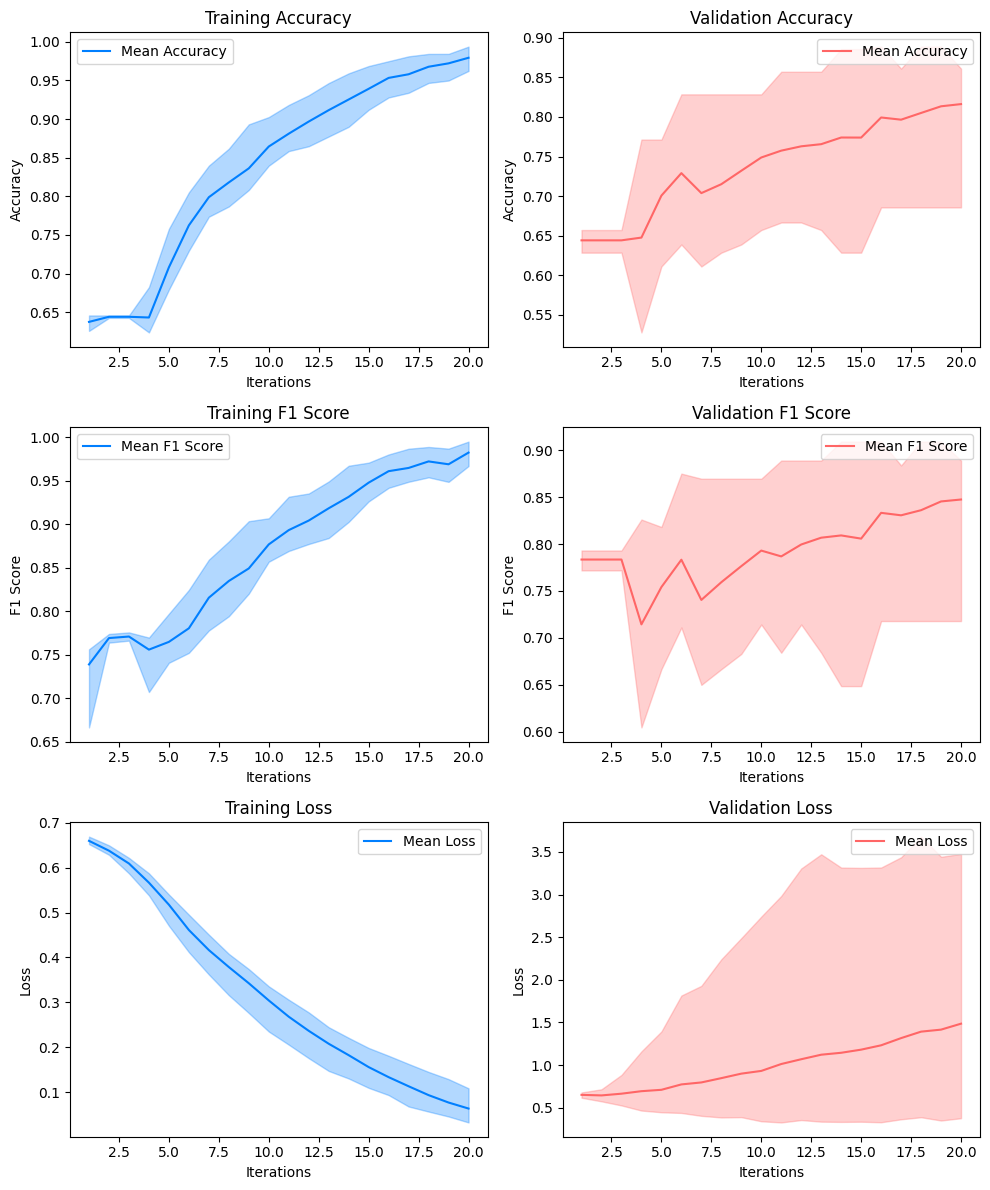

Processing Fold 1 ...


Epoch 5:   train/loss: 0.2456   valid/loss: 0.6307   train/acc: 0.7610   train/f1: 0.8557   valid/acc: 0.7500   valid/f1: 0.8571
Epoch 10:  train/loss: 0.4596   valid/loss: 0.6490   train/acc: 0.8113   train/f1: 0.8787   valid/acc: 0.6944   valid/f1: 0.8070
Epoch 15:  train/loss: 0.4768   valid/loss: 0.8085   train/acc: 0.8616   train/f1: 0.9084   valid/acc: 0.6667   valid/f1: 0.7857
Epoch 20:  train/loss: 0.1131   valid/loss: 0.9549   train/acc: 0.8836   train/f1: 0.9218   valid/acc: 0.6667   valid/f1: 0.7857

Training completed!


Processing Fold 2 ...


Epoch 5:   train/loss: 0.4865   valid/loss: 0.6037   train/acc: 0.7610   train/f1: 0.8568   valid/acc: 0.7500   valid/f1: 0.8571
Epoch 10:  train/loss: 0.2007   valid/loss: 0.8544   train/acc: 0.8208   train/f1: 0.8747   valid/acc: 0.6667   valid/f1: 0.7857
Epoch 15:  train/loss: 0.2400   valid/loss: 1.0925   train/acc: 0.9025   train/f1: 0.9321   valid/acc: 0.7222   valid/f1: 0.8077
Epoch 20:  train/loss: 0.0844   valid/loss: 1.4842   train/acc: 0.9308   train/f1: 0.9507   valid/acc: 0.7222   valid/f1: 0.8077

Training completed!


Processing Fold 3 ...


Epoch 5:   train/loss: 0.5150   valid/loss: 0.6744   train/acc: 0.7704   train/f1: 0.8588   valid/acc: 0.7500   valid/f1: 0.8571
Epoch 10:  train/loss: 0.1830   valid/loss: 0.8757   train/acc: 0.8396   train/f1: 0.8927   valid/acc: 0.6389   valid/f1: 0.7719
Epoch 15:  train/loss: 0.1962   valid/loss: 1.1331   train/acc: 0.8553   train/f1: 0.8972   valid/acc: 0.6667   valid/f1: 0.7692
Epoch 20:  train/loss: 0.1774   valid/loss: 1.6720   train/acc: 0.9151   train/f1: 0.9387   valid/acc: 0.6944   valid/f1: 0.7925

Training completed!


Processing Fold 4 ...


Epoch 5:   train/loss: 0.6233   valid/loss: 0.5224   train/acc: 0.7673   train/f1: 0.8586   valid/acc: 0.7500   valid/f1: 0.8571
Epoch 10:  train/loss: 0.6544   valid/loss: 0.5138   train/acc: 0.8050   train/f1: 0.8649   valid/acc: 0.7222   valid/f1: 0.8387
Epoch 15:  train/loss: 0.2743   valid/loss: 0.6598   train/acc: 0.8553   train/f1: 0.9057   valid/acc: 0.7500   valid/f1: 0.8421
Epoch 20:  train/loss: 0.2672   valid/loss: 0.8069   train/acc: 0.8836   train/f1: 0.9182   valid/acc: 0.7778   valid/f1: 0.8571

Training completed!


Processing Fold 5 ...


Epoch 5:   train/loss: 0.3191   valid/loss: 0.4884   train/acc: 0.7586   train/f1: 0.8550   valid/acc: 0.7714   valid/f1: 0.8710
Epoch 10:  train/loss: 0.6353   valid/loss: 0.5167   train/acc: 0.7994   train/f1: 0.8733   valid/acc: 0.8286   valid/f1: 0.8966
Epoch 15:  train/loss: 0.3639   valid/loss: 0.5803   train/acc: 0.8809   train/f1: 0.9219   valid/acc: 0.8000   valid/f1: 0.8727
Epoch 20:  train/loss: 0.1165   valid/loss: 0.6715   train/acc: 0.9279   train/f1: 0.9497   valid/acc: 0.8000   valid/f1: 0.8627

Training completed!


Processing Fold 6 ...


Epoch 5:   train/loss: 0.6199   valid/loss: 0.5052   train/acc: 0.7618   train/f1: 0.8547   valid/acc: 0.7714   valid/f1: 0.8710
Epoch 10:  train/loss: 0.3626   valid/loss: 0.4599   train/acc: 0.7649   train/f1: 0.8557   valid/acc: 0.7714   valid/f1: 0.8667
Epoch 15:  train/loss: 0.2357   valid/loss: 0.4875   train/acc: 0.8088   train/f1: 0.8711   valid/acc: 0.8571   valid/f1: 0.9091
Epoch 20:  train/loss: 0.1803   valid/loss: 0.5013   train/acc: 0.8370   train/f1: 0.8804   valid/acc: 0.6857   valid/f1: 0.7660

Training completed!


Processing Fold 7 ...


Epoch 5:   train/loss: 0.4190   valid/loss: 0.5353   train/acc: 0.7586   train/f1: 0.8568   valid/acc: 0.7714   valid/f1: 0.8710
Epoch 10:  train/loss: 0.1511   valid/loss: 0.5508   train/acc: 0.7680   train/f1: 0.8567   valid/acc: 0.7143   valid/f1: 0.8333
Epoch 15:  train/loss: 0.2724   valid/loss: 0.9138   train/acc: 0.8119   train/f1: 0.8729   valid/acc: 0.6571   valid/f1: 0.7778
Epoch 20:  train/loss: 0.1415   valid/loss: 1.6641   train/acc: 0.8746   train/f1: 0.9114   valid/acc: 0.5143   valid/f1: 0.6383

Training completed!


Processing Fold 8 ...


Epoch 5:   train/loss: 0.2469   valid/loss: 0.5237   train/acc: 0.7649   train/f1: 0.8563   valid/acc: 0.7714   valid/f1: 0.8710
Epoch 10:  train/loss: 0.1693   valid/loss: 0.4526   train/acc: 0.8307   train/f1: 0.8898   valid/acc: 0.8000   valid/f1: 0.8852
Epoch 15:  train/loss: 0.3435   valid/loss: 0.3430   train/acc: 0.8683   train/f1: 0.9102   valid/acc: 0.8000   valid/f1: 0.8852
Epoch 20:  train/loss: 0.0085   valid/loss: 0.2736   train/acc: 0.9404   train/f1: 0.9603   valid/acc: 0.7714   valid/f1: 0.8571

Training completed!


Processing Fold 9 ...


Epoch 5:   train/loss: 0.4214   valid/loss: 0.6763   train/acc: 0.7649   train/f1: 0.8586   valid/acc: 0.7714   valid/f1: 0.8710
Epoch 10:  train/loss: 0.9124   valid/loss: 1.1770   train/acc: 0.8339   train/f1: 0.8883   valid/acc: 0.7143   valid/f1: 0.8276
Epoch 15:  train/loss: 0.2983   valid/loss: 1.8536   train/acc: 0.8558   train/f1: 0.9036   valid/acc: 0.6857   valid/f1: 0.8070
Epoch 20:  train/loss: 0.0569   valid/loss: 2.7200   train/acc: 0.9342   train/f1: 0.9580   valid/acc: 0.6857   valid/f1: 0.8070

Training completed!


Processing Fold 10 ...


Epoch 5:   train/loss: 0.3844   valid/loss: 0.5741   train/acc: 0.7649   train/f1: 0.8592   valid/acc: 0.7143   valid/f1: 0.8333
Epoch 10:  train/loss: 0.2026   valid/loss: 0.8231   train/acc: 0.8245   train/f1: 0.8834   valid/acc: 0.6571   valid/f1: 0.7778
Epoch 15:  train/loss: 0.4953   valid/loss: 1.3411   train/acc: 0.8809   train/f1: 0.9201   valid/acc: 0.5714   valid/f1: 0.6939
Epoch 20:  train/loss: 0.3092   valid/loss: 1.7956   train/acc: 0.9154   train/f1: 0.9440   valid/acc: 0.6286   valid/f1: 0.7347

Training completed!


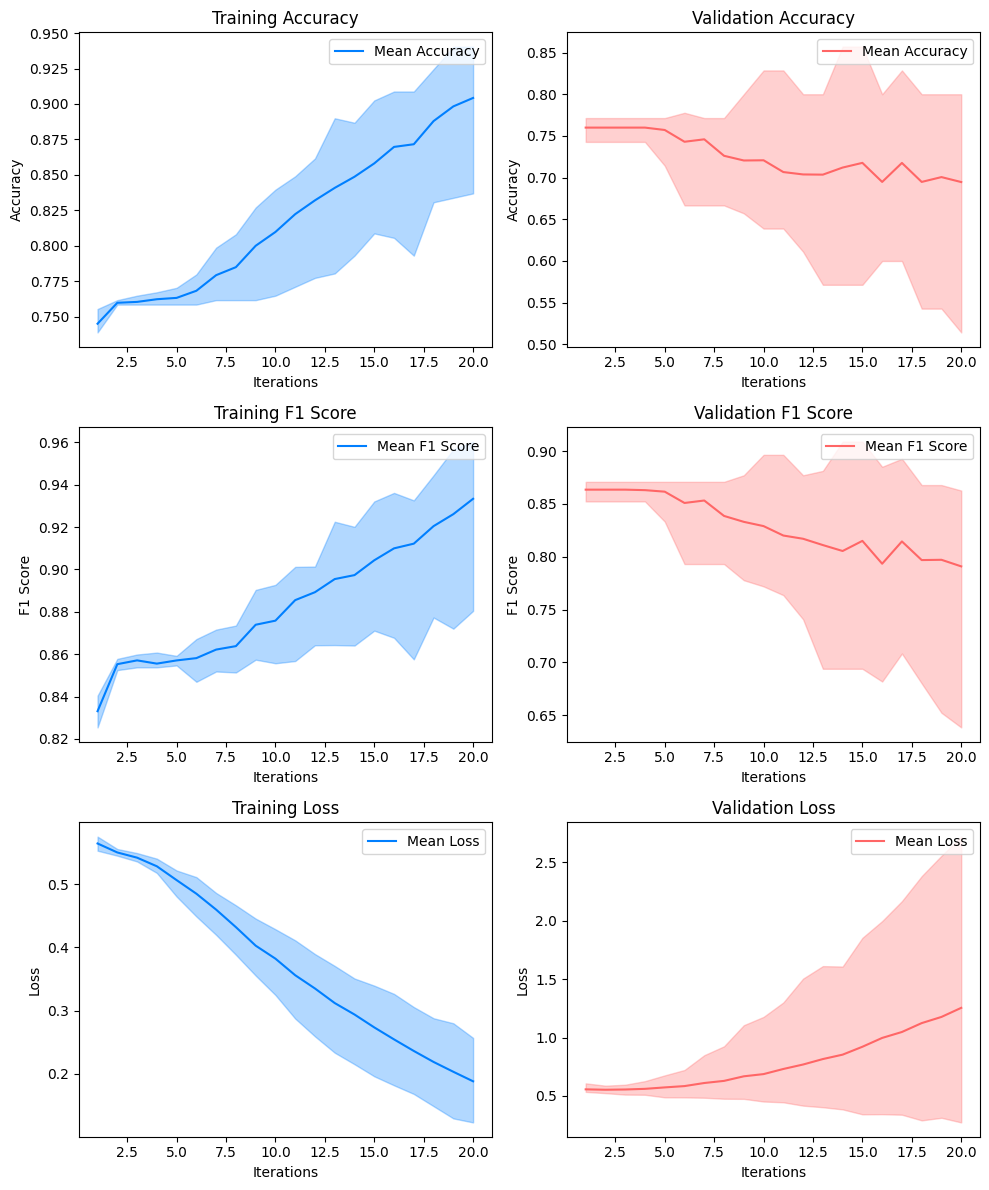

In [ ]:
EPOCHS = 20
SPLIT = 10
EARLY_STOPPING = None

custom_primary = '#007FFF'
custom_secondary = '#FF6666'

cv = StratifiedKFold(n_splits=SPLIT, random_state=SEED, shuffle=True)
networks_np = np.array(networks, dtype=object)

for targets in [pe_targets, o_targets, se_targets, us_targets]:

    targets_np = np.array(targets, dtype=object)

    # Grid search
    for lr in [1e-2]:
        for bs in [8]:

            train_accuracies = []
            val_accuracies = []
            train_losses = []
            val_losses = []
            train_f1 = []
            val_f1 = []

            for i, (train_index, val_index) in enumerate(cv.split(networks_np, targets_np.argmax(1))):

                print(f'Processing Fold {i+1} ...')

                train_fold = Dataset(networks_np[train_index], targets_np[train_index], batch_size=bs)
                val_fold = Dataset(networks_np[val_index], targets_np[val_index])

                model = ClassicalModel.from_diagrams(networks)
                model.initialise_weights

                trainer = PytorchTrainer(
                    model=model,
                    loss_function=torch.nn.BCEWithLogitsLoss(),
                    optimizer=torch.optim.AdamW,
                    learning_rate=lr,
                    epochs=EPOCHS,
                    evaluate_functions=eval_metrics,
                    evaluate_on_train=True,
                    verbose='text',
                    seed=SEED
                )

                trainer.fit(train_fold, val_fold, log_interval=5, early_stopping_interval=EARLY_STOPPING)

                train_accuracies.append(trainer.train_eval_results['acc'])
                val_accuracies.append(trainer.val_eval_results['acc'])

                train_f1.append(trainer.train_eval_results['f1'])
                val_f1.append(trainer.val_eval_results['f1'])

                train_losses.append(trainer.train_epoch_costs)
                val_losses.append(trainer.val_costs)

            range_ = np.arange(1, len(trainer.train_epoch_costs) + 1)

            # Calculate mean, min, and max metrics
            mean_train_accuracy = np.mean(train_accuracies, axis=0)
            min_train_accuracy = np.min(train_accuracies, axis=0)
            max_train_accuracy = np.max(train_accuracies, axis=0)

            mean_val_accuracy = np.mean(val_accuracies, axis=0)
            min_val_accuracy = np.min(val_accuracies, axis=0)
            max_val_accuracy = np.max(val_accuracies, axis=0)

            mean_train_f1 = np.mean(train_f1, axis=0)
            min_train_f1 = np.min(train_f1, axis=0)
            max_train_f1 = np.max(train_f1, axis=0)

            mean_val_f1 = np.mean(val_f1, axis=0)
            min_val_f1 = np.min(val_f1, axis=0)
            max_val_f1 = np.max(val_f1, axis=0)

            mean_train_loss = np.mean(train_losses, axis=0)
            min_train_loss = np.min(train_losses, axis=0)
            max_train_loss = np.max(train_losses, axis=0)

            mean_val_loss = np.mean(val_losses, axis=0)
            min_val_loss = np.min(val_losses, axis=0)
            max_val_loss = np.max(val_losses, axis=0)

            fig, axes = plt.subplots(3, 2, figsize=(10, 12))

            # Plot for training accuracy
            axes[0, 0].set_title('Training Accuracy')
            axes[0, 0].set_xlabel('Iterations')
            axes[0, 0].set_ylabel('Accuracy')
            axes[0, 0].plot(range_, mean_train_accuracy, color=custom_primary, label='Mean Accuracy')
            axes[0, 0].fill_between(range_, min_train_accuracy, max_train_accuracy, color=custom_primary, alpha=0.3)
            axes[0, 0].legend()

            # Plot for validation accuracy
            axes[0, 1].set_title('Validation Accuracy')
            axes[0, 1].set_xlabel('Iterations')
            axes[0, 1].set_ylabel('Accuracy')
            axes[0, 1].plot(range_, mean_val_accuracy, color=custom_secondary, label='Mean Accuracy')
            axes[0, 1].fill_between(range_, min_val_accuracy, max_val_accuracy, color=custom_secondary, alpha=0.3)
            axes[0, 1].legend()

            # Plot for training F1 score
            axes[1, 0].set_title('Training F1 Score')
            axes[1, 0].set_xlabel('Iterations')
            axes[1, 0].set_ylabel('F1 Score')
            axes[1, 0].plot(range_, mean_train_f1, color=custom_primary, label='Mean F1 Score')
            axes[1, 0].fill_between(range_, min_train_f1, max_train_f1, color=custom_primary, alpha=0.3)
            axes[1, 0].legend()

            # Plot for validation F1 score
            axes[1, 1].set_title('Validation F1 Score')
            axes[1, 1].set_xlabel('Iterations')
            axes[1, 1].set_ylabel('F1 Score')
            axes[1, 1].plot(range_, mean_val_f1, color=custom_secondary, label='Mean F1 Score')
            axes[1, 1].fill_between(range_, min_val_f1, max_val_f1, color=custom_secondary, alpha=0.3)
            axes[1, 1].legend()

            # Plot for training loss
            axes[2, 0].set_title('Training Loss')
            axes[2, 0].set_xlabel('Iterations')
            axes[2, 0].set_ylabel('Loss')
            axes[2, 0].plot(range_, mean_train_loss, color=custom_primary, label='Mean Loss')
            axes[2, 0].fill_between(range_, min_train_loss, max_train_loss, color=custom_primary, alpha=0.3)
            axes[2, 0].legend()

            # Plot for validation loss
            axes[2, 1].set_title('Validation Loss')
            axes[2, 1].set_xlabel('Iterations')
            axes[2, 1].set_ylabel('Loss')
            axes[2, 1].plot(range_, mean_val_loss, color=custom_secondary, label='Mean Loss')
            axes[2, 1].fill_between(range_, min_val_loss, max_val_loss, color=custom_secondary, alpha=0.3)
            axes[2, 1].legend()

            plt.tight_layout()
            plt.show()